# Preparation
First download the t7 file from http://cs.nott.ac.uk/~psxasj/download.php?file=vrn-unguided.t7

I use https://github.com/bshillingford/python-torchfile to parse the torch file.

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../python-torchfile')
import torchfile

t = torchfile.load('vrn-unguided.t7')

In [14]:
t.__dir__()

['output', '_type', 'train', 'modules', 'gradInput', 'torch_typename']

In [20]:
t['modules'][0].__dir__()

['weight',
 'nOutputPlane',
 'gradWeight',
 'bias',
 'nInputPlane',
 'padH',
 'padW',
 'fgradInput',
 '_type',
 'finput',
 'fmode',
 'kH',
 'bwmode',
 'train',
 'kW',
 'groups',
 'gradBias',
 'dW',
 'dH',
 'gradInput',
 'bdmode',
 'output',
 'torch_typename']

In [40]:
t._typename

'nn.Sequential'

In [41]:
def lst(tobj):
    for module in tobj['modules']:
        print("{}\t{}".format(module._typename, module['weight'].shape if 'weight' in module.__dir__() else ''))

lst(t)

nn.SpatialConvolution	(64, 3, 7, 7)
nn.SpatialBatchNormalization	(64,)
nn.ReLU	
nn.Sequential	
nn.SpatialMaxPooling	
nn.Sequential	
nn.Sequential	
nn.ConcatTable	
nn.CAddTable	
nn.ConcatTable	
nn.CAddTable	
nn.ConcatTable	


In [93]:
ln = 0
list_file = open("list.txt", "w")

def lst(tobj, indent, f):
    global ln
    for module in tobj['modules']:
        f.write("{}\t{}{}\t{}\n".format(ln,
                                    "    " * indent,
                                    module._typename,
                                    module['weight'].shape if 'weight' in module.__dir__() else ''))
        ln += 1
        if 'modules' in module.__dir__():
            lst(module, indent + 1, f)

lst(t, 0, list_file)
list_file.close()

In [2]:
import numpy as np

def getr(tobj, ln):
    for module in tobj['modules']:
        if ln == 0:
            return module, 0
        ln -= 1
        if 'modules' in module.__dir__():
            got, ln = getr(module, ln)
            if got is not None:
                return got, 0

    return None, ln

def get(tobj, ln):
    tout, _ = getr(tobj, ln)
    return tout

def info(module):
    print("{}".format(module._typename))
    for prop in module.__dir__():
        value = module[prop]
        if value.__class__ == np.ndarray:
            value = value.shape
        if value.__class__ == list:
            value = value[0].shape
        print("{}\t{}".format(prop, value))

In [77]:
info(get(t, 11))

nn.SpatialConvolution
weight	(64, 64, 3, 3)
nOutputPlane	64
gradWeight	(64, 64, 3, 3)
bias	(64,)
nInputPlane	64
padH	1
padW	1
fgradInput	(0,)
_type	torch.FloatTensor
finput	(1, 576, 9216)
fmode	1
kH	3
bwmode	1
train	True
kW	3
groups	1
gradBias	(64,)
dW	1
dH	1
gradInput	(0,)
bdmode	1
output	(1, 64, 96, 96)
torch_typename	None


In [41]:
get(t, 0)['finput']

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)

In [35]:
tobj = get(t, 48)
top = tobj['modules'][1]
a, b = top['modules'][:3:2]
info(a)
info(b)

nn.ConcatTable
output	(1, 256, 48, 48)
_type	torch.FloatTensor
train	True
modules	None
gradInput	(0,)
torch_typename	None
nn.Sequential
output	(1, 256, 48, 48)
_type	torch.FloatTensor
train	True
modules	None
gradInput	(0,)
torch_typename	None


In [138]:
t['gradInput']

array([], dtype=float32)

In [9]:
from keras.layers import Input, Conv2D
from keras.models import Model

In [5]:
from model import Conv131
tconv, _ = get(t, 55)

In [16]:
from keras import backend as K
from model import UpSamplingBilinear

input = Input((256, 48, 48))
out = UpSamplingBilinear()(input)
model = Model(inputs=input, outputs=out)
model.compile(loss='mean_squared_error', optimizer='sgd')

ind = get(t, 47)
ind = ind['output']

model.predict(ind).shape

(1, 256, 192, 192)

In [3]:
from model import model
model = model(t)

Using TensorFlow backend.


Half 1
Part 0
Part 1
Part 2
Part 3
Half 2
Part 0
Part 1
Part 2
Part 3


In [4]:
import cv2
img = cv2.imread('test.jpg')
img = cv2.resize(img, (192, 192))
img = np.swapaxes(img, 2, 0)
img = np.swapaxes(img, 2, 1)
img = np.array([img])

In [42]:
z = np.zeros((1, 3, 192, 192))

In [43]:
pred = model.predict(z)

In [6]:
model.get_config()

{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 3, 192, 192),
    'dtype': 'float32',
    'name': 'input_1',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'ZeroPadding2D',
   'config': {'data_format': 'channels_first',
    'name': 'zero_padding2d_1',
    'padding': ((3, 3), (3, 3)),
    'trainable': True},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'zero_padding2d_1'},
  {'class_name': 'Conv',
   'config': {'activation': 'linear',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_first',
    'dilation_rate': (1, 1),
    'filters': 64,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': Non

In [47]:
tmodel = Model(inputs=model.input, outputs=model.get_layer('up_sampling_bilinear_1').output)
test = tmodel.predict(z)

In [49]:
d = get(t, 1337)['output']

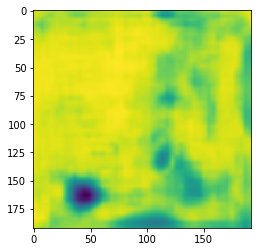

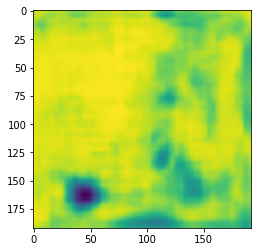

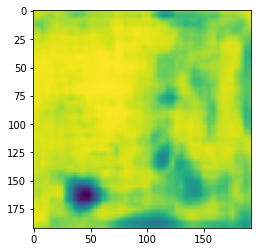

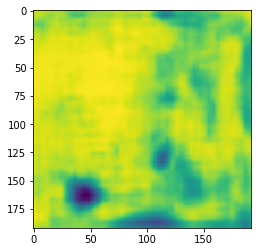

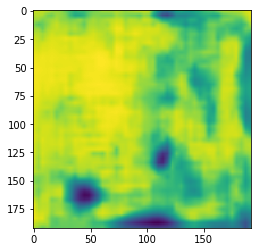

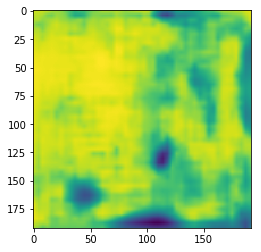

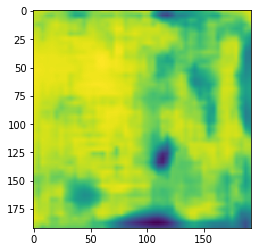

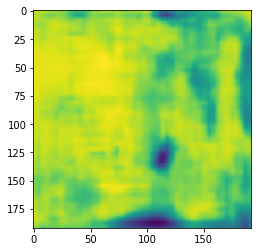

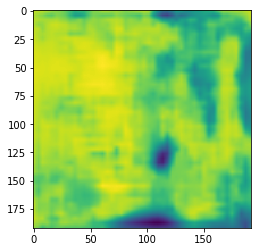

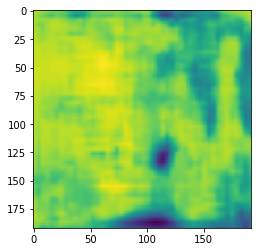

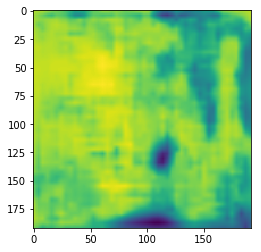

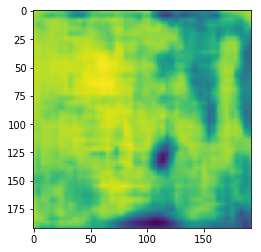

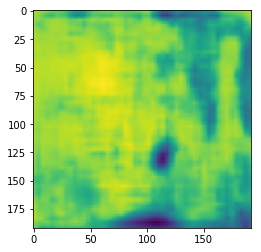

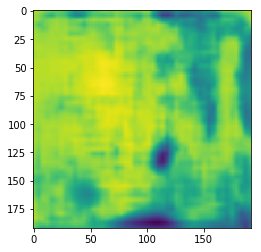

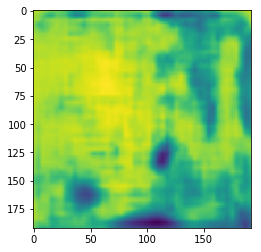

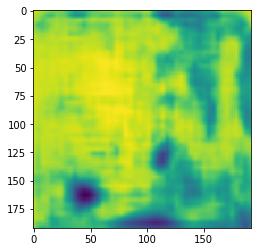

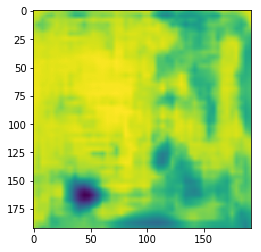

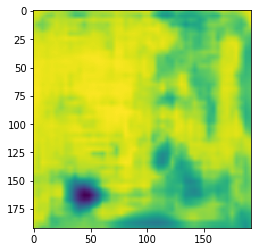

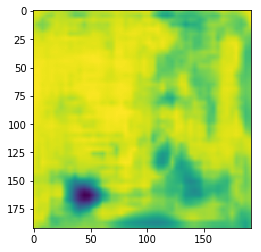

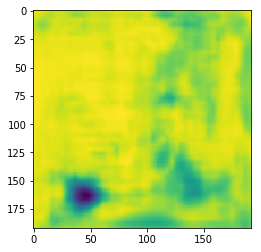

In [50]:
from matplotlib import pyplot as plt
# test2 = test
# test2[test<0] = 0
for p in d[0][::10]:
    plt.imshow(p)
    plt.show()

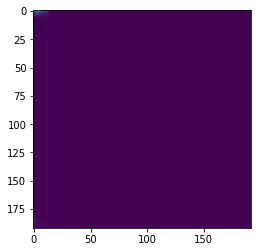

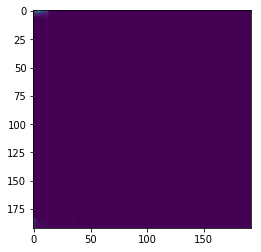

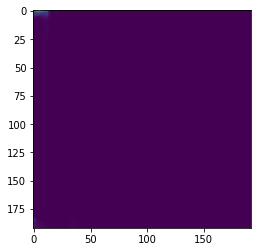

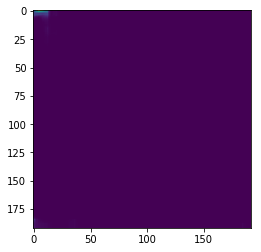

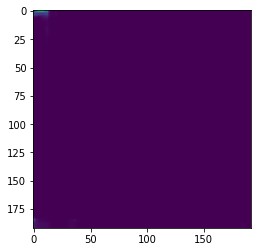

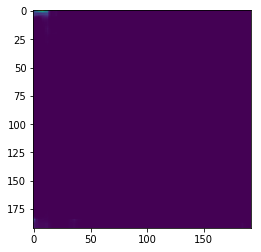

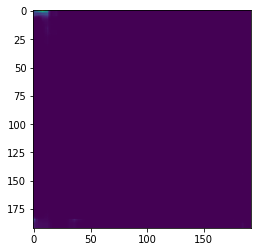

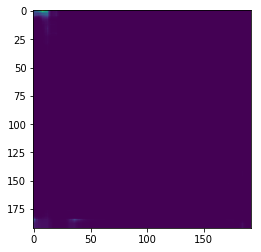

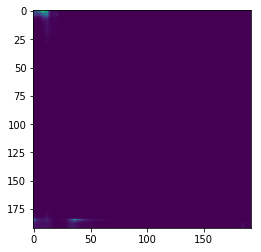

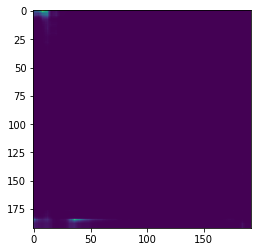

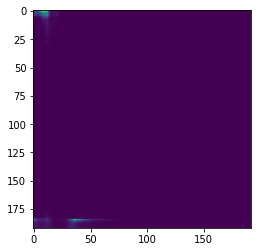

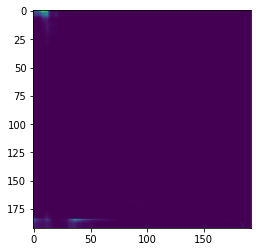

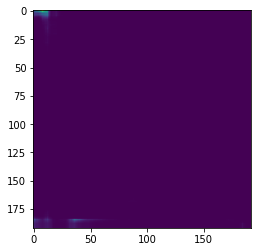

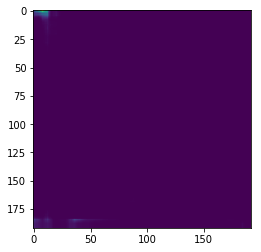

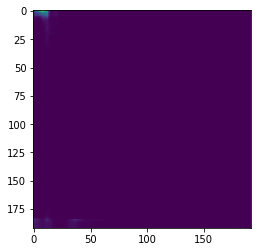

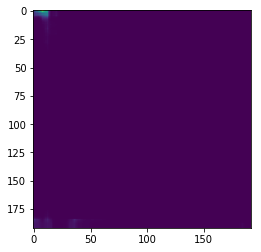

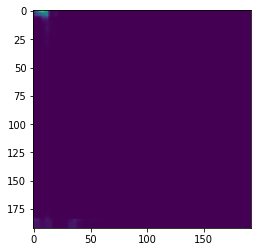

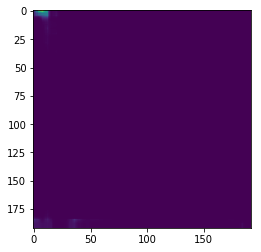

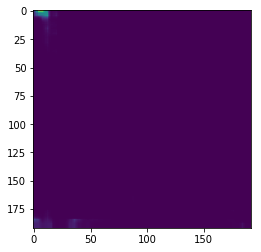

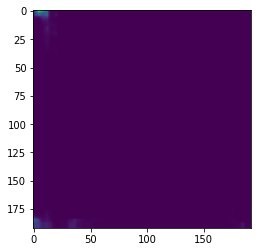

In [44]:

from matplotlib import pyplot as plt
for p in pred[0][::10]:
    plt.imshow(p)
    plt.show()
#     plt.imshow(t)
#     plt.show

In [24]:
np.max(test[0])

-108.9442

In [14]:
np.mean(get(t, 1327)['output'][0][0])

0.66114467

In [16]:
get(t, 1327)['bias'][0]

0.31954193

In [32]:
model.get_layer('batch_norm_546').get_config()

{'axis': 1,
 'beta_constraint': None,
 'beta_initializer': {'class_name': 'Zeros', 'config': {}},
 'beta_regularizer': None,
 'center': True,
 'epsilon': 1e-05,
 'gamma_constraint': None,
 'gamma_initializer': {'class_name': 'Ones', 'config': {}},
 'gamma_regularizer': None,
 'momentum': 0.1,
 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}},
 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}},
 'name': 'batch_norm_546',
 'scale': True,
 'trainable': True}